<a href="https://colab.research.google.com/github/AshOne91/PLAYDATA-COLAB/blob/main/%EB%8B%A4%EC%B0%A8%EC%9B%90_%EB%B0%B0%EC%97%B4%EC%9D%98_%EA%B3%84%EC%82%B0%2C_%EC%B6%9C%EB%A0%A5%EC%B8%B5_%EC%84%A4%EA%B3%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 손글씨 분류하기 : 다중 분류
```
데이터 가져오기
데이터 확인 - 몇개의 셈플을 출력, 클래스 수 (10)
모델 정의 및 학습 - MLP(다층레이어)
  마지막층 10개
  회귀 : 출력층이 1  손실함수 MSE
  이진분류 : 출력층이 1  손실함수 binary cross entropy
  다중 분류 : 출력층이 클래수 손실함수 cross entropy
성능평가
추론(예측)
```

In [ ]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
# 지정된 데이터셋 반환
training_data = MNIST(
    root = './',
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = MNIST(
    root = './',
    train = False,
    download = True,
    transform = ToTensor()
)
# 1 내용 확인
for img, label in test_data:
  print(img.shape, label)
  break
# 2 내용 확인
img, label = next(iter(test_data))
print(img.shape, label)

torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 7


torch.Size([1, 28, 28]) torch.Size([28, 28, 1]) 7


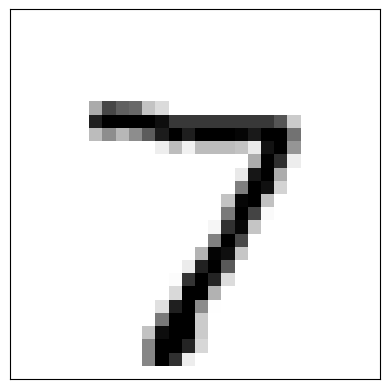

In [ ]:
import matplotlib.pyplot as plt
img, label = next(iter(test_data))
print(img.shape,  img.permute(1,2,0).shape,   label)
# plt.imshow(img[0], cmap="gray_r")
plt.imshow(img.permute(1,2,0), cmap="gray_r")  #permute :  1 28 28 --> 28 28 1
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
imgs = {}
for img, label in training_data:
  if label not in imgs:
    imgs[label] = img
    if len(imgs) == 10:
      break

In [ ]:
imgs = dict(sorted(imgs.items(), key=lambda x: x[0]))

In [ ]:
imgs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

데이터 시각화 (2,5)

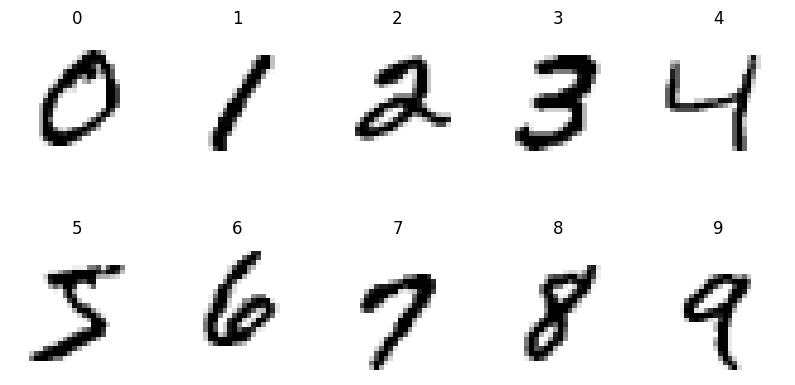

In [ ]:
_,axes =  plt.subplots(2,5, figsize = (10,5))

for i, (label,img) in enumerate(imgs.items()):
  axes[ i//5 , i%5].imshow(img.permute(1,2,0), cmap='gray_r')
  axes[ i//5 , i%5].set_title(label)
  axes[i//5, i%5].axis('off')
plt.show()

데이터 로더로 데이터셋을 섞고 배치단위로 분할

In [ ]:
from torch.utils.data.dataloader import DataLoader
train_loader = DataLoader(training_data, batch_size=32,shuffle=True)
test_loader = DataLoader(test_data, batch_size=32,shuffle=False)
img,label = next(iter(test_loader))
img.shape   # 32,1,28,28

torch.Size([32, 1, 28, 28])

In [ ]:
import torch.nn as nn
import torch

# 모델 클래스
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden1 = nn.Linear(28*28,100)
    self.hidden2 = nn.Linear(100,50)
    self.output = nn.Linear(50,10)
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.relu(self.hidden1(x))
    x = self.relu(self.hidden2(x))
    output = self.output(x)
    return output
mlp_model = MLP()
mlp_model

MLP(
  (hidden1): Linear(in_features=784, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
data, label = next(iter(train_loader))
print(data[0].reshape(-1,28*28).shape)
mlp_model(data[0].reshape(-1,28*28)) #  mat1 and mat2 shapes cannot be multiplied (896x28 and 784x100)

torch.Size([1, 784])


tensor([[ 0.0094, -0.1263,  0.0942,  0.0698, -0.1254,  0.0311,  0.0343,  0.0296,
         -0.1108,  0.0821]], grad_fn=<AddmmBackward0>)

학습루프

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mlp_model.to(device)

epochs = 20
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(mlp_model.parameters())
for epoch in range(epochs):
  for data, label in train_loader:  # torch.Size([32, 1, 28, 28])
    data = data.to(device)
    label = label.to(device)
    data = data.reshape(-1,28*28)  # torch.Size([32, 784])
    output = mlp_model(data)  # 예측
    loss = loss_fn(output, label)  # 오차
    loss.backward() # 오차 역전파
    optim.step()  # 가중치 업데이트
    optim.zero_grad() # 기울기 초기화
  print(f'epoch {epoch+1} loss {loss.item() / len(train_loader)}') # item() 텐서에서 분리

# 모델 저장
torch.save(mlp_model.state_dict(), 'MNIST_pth')

epoch 1 loss 9.142544269561767e-05
epoch 2 loss 3.29166054725647e-05
epoch 3 loss 1.587612827618917e-05
epoch 4 loss 3.317197362581889e-05
epoch 5 loss 8.373785813649496e-05
epoch 6 loss 6.270843744277954e-06
epoch 7 loss 4.7282288471857705e-06
epoch 8 loss 1.620655506849289e-06
epoch 9 loss 1.5300232917070388e-06
epoch 10 loss 1.3838971654574077e-06
epoch 11 loss 4.107392231623332e-05
epoch 12 loss 1.5505241851011912e-07
epoch 13 loss 1.5327372898658117e-06
epoch 14 loss 5.9368380655845e-07
epoch 15 loss 6.781205336252849e-05
epoch 16 loss 2.245334287484487e-07
epoch 17 loss 1.8523408720890681e-06
epoch 18 loss 2.173309773206711e-06
epoch 19 loss 2.773728221654892e-07
epoch 20 loss 1.0547274723649025e-07


저장된 모델 불러오기

In [ ]:
loaded_model = MLP()
loaded_model.load_state_dict(torch.load('MNIST_pth', map_location=device))

<All keys matched successfully>

평가

In [ ]:
import numpy as np
corrects = 0
with torch.no_grad():  # 기울기 계산을 안함
  for data, label in test_loader:
    data = data.to(device)  # (32,1,28,28) -- > (32, 28*28)  nn.Linear(28*28,100)
    label = label.to(device)
    data = data.reshape(-1,28*28)
    predict = loaded_model(data)  #
    # a = np.argmax(predict.numpy(),axis=1)  #predict.numpy()  tensor ->numpy
    # b = label.numpy()
    # corrects += (a==b).sum()
    corrects += predict.max(dim=-1)[1].eq(label).sum().item()

corrects / len(test_loader.dataset)

0.977

# 사진 분류   CNN vs VGG
```
CNN 설명
데이터 전처리
  데이터 증강
  이미지 정규화
CNN으로 이미지 분류
  모델정의
  모델학습
  성능평가
VGG(전이학습)
  사전학습된 모델 불러오기    
```


100%|██████████| 170M/170M [00:02<00:00, 58.4MB/s]


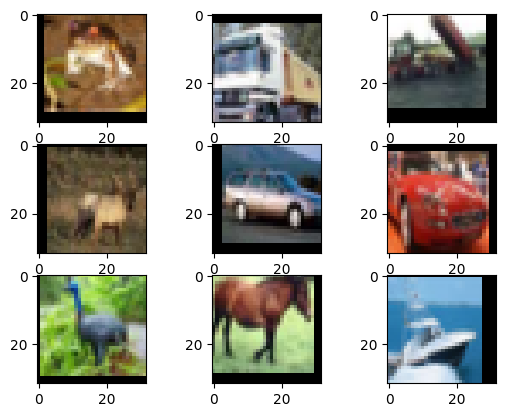

In [ ]:
# 기존 데이터를 변
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Compose
transform = Compose([
    ToTensor(),
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5)
])
training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform= transform  # 데이터를 가져올때 변경을 어떻게 할것인지.
)
test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = transform  # 데이터를 가져올때 변경을 어떻게 할것인지.
)
for idx, (data ,label) in enumerate(training_dataset):
  plt.subplot(3,3,idx+1)
  plt.imshow(data.permute(1,2,0))
  if idx == 8:
    break
plt.show()


이미지 정규화

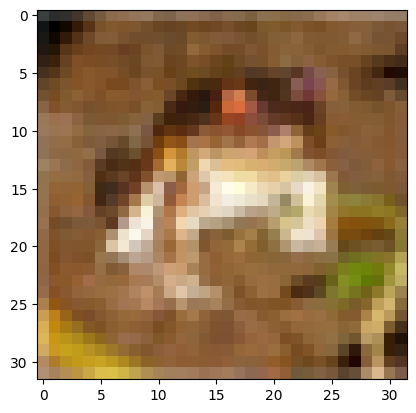

In [ ]:
from torchvision.transforms import Normalize
import torchvision.transforms as T
transform = Compose([
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean = (0.45,0.45,0.45), std= (0.25,0.25,0.25)), # RGB에 대한 각각의 평균과 표준편차를 적용
])
training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform= transform  # 데이터를 가져올때 변경을 어떻게 할것인지.
)
test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = transform  # 데이터를 가져올때 변경을 어떻게 할것인지.
)
for img in training_dataset.data:
  plt.imshow(img)
  break

CIFA10 의 RGB의 각각의 평균과 표준편차

In [ ]:
temp = CIFAR10(
    root='./temp',
    train=True,
    download=True,
    transform= ToTensor()
    )
print(temp.data.shape)

(50000, 32, 32, 3)


In [ ]:
print(temp.data[0].shape)
def calc_mean_std(img):
  return img[:,:,0].mean(),img[:,:,1].mean(),img[:,:,2].mean()
  # print(img[0,:,:].std(),img[1,:,:].std(),img[2,:,:].std())

calc_mean_std(temp.data[0])

(32, 32, 3)


(np.float64(141.205078125),
 np.float64(105.099609375),
 np.float64(64.037109375))

모델은 VGG 형태로 만든다
```
기본블럭(BasicBlock)
합성곱(3x3) - relu - 합성곱(3x3) -relu - 맥스폴링 - 출력
```

In [ ]:
import torch
import torch.nn as nn
class BasicBlock(nn.Module):
  def __init__(self,in_channels=3, hidden_channel = 32,out_channels=16):
    super().__init__()                                                     # 입력데이터 모양 torch.Size([3, 32, 32])
    self.conv1 = nn.Conv2d(in_channels,hidden_channel,kernel_size=3,padding=1)  # in_channels 는 RGB 채널수 64 --> (32,32,32)
    self.conv2 = nn.Conv2d(hidden_channel,out_channels,kernel_size=3,padding=1) # (16,32,32)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(2)                        #(16,16,16)
  def forward(self,x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.maxpool(x)
    return x

In [ ]:
test_block = BasicBlock()
for data ,label in training_dataset:
  print(data.shape)
  result = test_block(data)
  print(result.shape)
  break

NameError: name 'training_dataset' is not defined

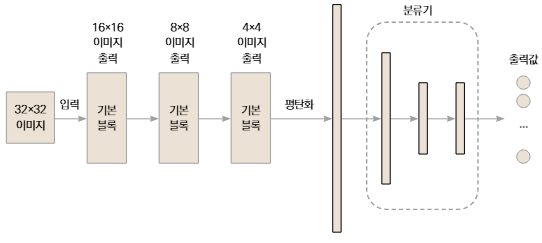

In [ ]:
class CNN(nn.Module):
  def __init__(self) -> None:
    super().__init__()  # VGG16 대략 이런 파라메터
    self.block1 = BasicBlock(in_channels=3,hidden_channel=32,out_channels=16)   # (None, 16,16,16)
    self.block2 = BasicBlock(in_channels=16,hidden_channel=64,out_channels=128)  #(None,128,8,8)
    self.block3 = BasicBlock(in_channels=128,hidden_channel=128,out_channels=256) #(None,256,4,4)
    self.linear1 = nn.Linear(in_features = 256*4*4, out_features = 2048)
    self.linear2 = nn.Linear(in_features = 2048 , out_features=256)
    self.linear3 = nn.Linear(in_features = 256 , out_features=10)
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    # print(x.shape)  # None,256,4,4  ()
    x = torch.flatten(x, start_dim=1)  #(None,256*4*4)
    x =self.relu( self.linear1(x))
    x =self.relu( self.linear2(x))
    x =self.linear3(x)
    return x


# temp_model = CNN()
# for data, label in training_dataset:
#   result = temp_model(data)
#   print(result)
#   break

In [ ]:
# 데이터가져오기 - 데이터변환 - 데이터로더 - 모델 생성 - 훈련함수, 평가함수
from torchvision.datasets.cifar import CIFAR10
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import ToTensor,Normalize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Compose
from torch.optim.adam import Adam
# 원본데이터를 변형한 데이터
transforms = Compose([
    RandomCrop((32,32), padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean = (0.4,0.4,0.4),std=(0.2,0.2,0.2))
])
training_dataset = CIFAR10(root='./',train=True,download=True,transform=transforms)
test_dataset = CIFAR10(root='./',train=False,download=True,transform=transforms)
training_dataloader = DataLoader(training_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(training_dataset,batch_size=64)
device = "cuda" if torch.cuda.is_available() else "cpu"
#모델
model = CNN().to(device)
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optim = Adam(model.parameters(),lr=0.001)
#학습루프
for epoch in range(epochs):
  for data, label in training_dataloader:
    data = data.to(device)
    label = label.to(device)
    predict = model(data)
    loss = loss_fn(predict,label)
    loss.backward()
    optim.step()
    optim.zero_grad()
  print(f'epoch : {epoch+1} loss : {loss / len(training_dataloader)}')
# 모델 저장
torch.save(model.state_dict(),'vggcnn.pth')

100%|██████████| 170M/170M [00:06<00:00, 25.3MB/s]


epoch : 1 loss : 0.001484507811255753
epoch : 2 loss : 0.0012410474009811878
epoch : 3 loss : 0.001222836202941835
epoch : 4 loss : 0.0009136571898125112
epoch : 5 loss : 0.0008086060406640172
epoch : 6 loss : 0.0007363727199845016
epoch : 7 loss : 0.00047828772221691906
epoch : 8 loss : 0.0011055913055315614
epoch : 9 loss : 0.0011928834719583392
epoch : 10 loss : 0.0005634886911138892


In [ ]:
# 모델 로드
vggcnn_loaed_model = CNN()
vggcnn_loaed_model.load_state_dict(torch.load('vggcnn.pth',map_location=device))
vggcnn_loaed_model = vggcnn_loaed_model.to(device)

평가

In [ ]:
with torch.no_grad():
  corrects = 0
  for data,label in test_dataloader:
    data = data.to(device)
    label = label.to(device)
    predict = vggcnn_loaed_model(data)
    # predict.data.max(dim=1)  32,10 --> 32개 셈플의 max값과 index값이 튜플로
    preds = predict.data.max(dim=1)[1]  # max에  해당하는 index
    corrects += preds.eq(label).sum().item()

corrects / len(test_dataloader.dataset)

0.80254

추론

In [ ]:
import matplotlib.pyplot as plt
original = CIFAR10(root='./',train=False,download=True,transform=ToTensor())
data, label = next(iter(original))
print(data.shape)

torch.Size([3, 32, 32])


In [ ]:
for idx,(data, label) in enumerate(original):
  result = vggcnn_loaed_model(data.reshape(-1,3,32,32).to(device))
  print(result.max(1)[1].item(), label)
  if idx == 10:
    break

4 3
8 8
8 8
0 0
3 6
4 6
0 1
4 6
4 3
8 1
0 0


데이터 합치기
```
원본 + 크랩된 데이터
from torch.utils.data import ConcatDataset
```

In [ ]:
from torch.utils.data import ConcatDataset
# ConcatDataset([CIAR10데이터셋, CIAR10데이터셋변경한거]])

# VGG16

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.vgg import vgg16
# 모델 불러오기
vgg16_model = vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
summary(vgg16_model.to(device), input_size=(3,32,32) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
# 전이학습중에서 분류기를 다시 설계할때
class_model = nn.Sequential(
    nn.Linear(in_features=25088,out_features = 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=10)
)
vgg16_model.classifier = class_model
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# 출력의 개수만 변경
vgg16_model2 = vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
in_features = vgg16_model2.classifier[6].in_features  # 4096
vgg16_model2.classifier[6] = nn.Linear(in_features=in_features,out_features=10)
vgg16_model2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

전이모델로 학습하기

In [ ]:
vgg16_model2 = vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
# # 모든 파라메터 업데이트를 금지
# # vgg16의 가중치를 고정하고 마지막 분류기의 레이어만 학습
for param in vgg16_model2.parameters():
  param.requires_grad  = False

in_features = vgg16_model2.classifier[6].in_features  # 4096
vgg16_model2.classifier[6] = nn.Linear(in_features=in_features,out_features=10)


# # 분류기만 학습하고 나머지는 가중치를 고정
# for param in vgg16_model2.features.parameters():
#   param.requires_grad  = False
# for param in vgg16_model2.classifier.parameters():
#   param.requires_grad  = True

## 전체 가중치를 고정
# for param in vgg16_model2.parameters():
#   param.requires_grad  = False

# # 전체 가중치를 해제
# for param in vgg16_model2.parameters():
#   param.requires_grad  = True

# 데이터셋, 데이터 로더
vgg16_model2.to(device)
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean = (0.4,0.4,0.4),std=(0.2,0.2,0.2))
])
train_dataset = CIFAR10(root='./',train=True,download=True,transform=transforms)
test_dataset = CIFAR10(root='./',train=False,download=True,transform=transforms)
train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=64)
# 모델학습  데이터로더를 for 로 학습루프
loss_fn = nn.CrossEntropyLoss()
optim = Adam(vgg16_model2.parameters(),lr=1e-4)
for epoch in range(30):
  running_loss  = 0.0
  for data, label in train_dataloader:
    data = data.to(device)
    label = label.to(device)
    predict = vgg16_model2(data)
    loss = loss_fn(predict,label)
    loss.backward()
    optim.step()
    optim.zero_grad()
    running_loss  += loss.item()
  print(f'epoch : {epoch+1} loss : {running_loss / len(train_dataloader)}')
# 평가
with torch.no_grad():
  corrects = 0
  for data,label in test_dataloader:
    data = data.to(device)
    label = label.to(device)
    predict = vgg16_model2(data)
    predict = predict.data.max(dim=1)[1]  # max에  해당하는 index
    corrects += predict.eq(label).sum().item()
corrects / len(test_dataloader.dataset)

epoch : 1 loss : 0.9278101578088063
epoch : 2 loss : 0.6309981996293568
epoch : 3 loss : 0.5853731372510381
epoch : 4 loss : 0.5649694664703916
epoch : 5 loss : 0.5523907882935556


In [ ]:
# 평가
with torch.no_grad():
  corrects = 0
  for data,label in test_dataloader:
    data = data.to(device)
    label = label.to(device)
    predict = vgg16_model2(data)
    print(predict.data[0])
    # predict = predict.data.max(dim=1)[1]  # max에  해당하는 index
    # print(predict)
    # print(label)
    break
#     corrects += predict.eq(label).sum().item()
# corrects / len(test_dataloader.dataset)

tensor([-4.1479,  1.0886, -2.7571, -0.6153, -7.9681, -3.7441, -1.0932, -6.2424,
        -5.8744, -0.7344], device='cuda:0')
